## EPIC beadchip DNA methylation Analysis. 

### Basic Steps.
1. import idat files into an rgSet object
2. Generate a QC report
3. Get Annotation
4. Normalization and correct probe type bias
5. Identify Differentially methylated regions (DMR) and differentially methylated cytosines (DMC)

In [1]:
# Load libraries

# packages
library("minfi")
library("IlluminaHumanMethylationEPICmanifest")
library("IlluminaHumanMethylationEPICanno.ilm10b4.hg19")
#library("GGally")  # like ggplot ; NOTE: NOT installed yet
library("wateRmelon")  # normalize probe bias
library("missMethyl")  # gometh go terms
library("CpGassoc")
#library(xlsx)
library(stringr)
library(ggfortify)  # for the autoplot function in PCA plots

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors


At

In [2]:
getwd()

[1] "/home/sbyrum/Scripts/Jupyter/02_EPIC_methylation"

In [ ]:
sessionInfo()

<b> NOTE: Check all of the libraries loaded properly </b>

<b> Illumina EPIC Bead Based Technology</b>
<p> Illumina microarray technology (also known as BeadArray technology) uses silica microbeads. 
On the surface of each array, or BeadChip, hundreds of thousands to millions of genotypes for a single individual can be assayed at once. 
These tiny silica beads are housed in carefully etched microwells and coated with multiple copies of an oligonucleotide probe targeting a specific locus in the genome.</p>
<p> As DNA fragments pass over the BeadChip, each probe binds to a complementary sequence in the sample DNA, stopping one base before the locus of interest. Allele specificity is conferred by a single base extension that incorporates one of four labeled nucleotides. When excited by a laser, the nucleotide label emits a signal. The intensity of that signal conveys information about the allelic ratio at that locus.</p>
    

In [3]:
## import EPIC data from a sample sheet and idat files

idatPath <- "/home/sbyrum/Scripts/Jupyter/02_EPIC_methylation/download/" # path of the folder
targets <- read.csv("/home/sbyrum/Scripts/Jupyter/02_EPIC_methylation/download/SampleSheet.csv", strip.white=T, stringsAsFactors=F) #sample information
targets$File_Name = paste(targets$Sentrix_ID, targets$Sentrix_Position, sep = "_")
targets$Basename <- targets$File_Name # name of the files

Load in the data and map the sample information to the raw idat sequencing files

<b>The MINFI package is designed to be very flexible for methods developers. This flexibility comes at a cost for users; they need to understand a few different data classes:</b>

<p><b>RGChannelSet :</b> raw data from the IDAT files; this data is organized at the probe (not CpG locus) level. This data has two channels: Red and Green.</p>
<p><b>MethylSet :</b> data organized by the CpG locus level, but not mapped to a genome. This data has two channels: Meth (methylated) and Unmeth (unmethylated).</p>
<p><b>RatioSet :</b> data organized by the CpG locus level, but not mapped to a genome. The data has at least one of two channels: Beta and/or M (logratio of Beta). It may optionally include a CN channel (copy number).</p>
<p><b>GenomicMethylSet :</b> like a MethylSet, but mapped to a genome.</p>
<p><b>GenomicRatioSet :</b> like a RatioSet, but mapped to the genome.</p>
<p> We are using the RGChannel Set in this example </p>

In [4]:
rgSet <- read.metharray.exp(base=idatPath, targets=targets, verbose=T) # read the idat file one by one 

[read.metharray] Reading 203550290094_R01C01_Grn.idat

Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
[read.metharray] Reading 203550290094_R02C01_Grn.idat

Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
[read.metharray] Reading 203550290094_R03C01_Grn.idat

Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
[read.metharray] Reading 203550290094_R04C01_Grn.idat

Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
[read.metharray] Reading 203550290094_R05C01_Grn.idat

Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
[read.metharray] Reading 203550290094_R06C01_Grn.idat

Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
[read.metharray] Reading 203550290094_R07C01_Grn.idat

Warning message in readChar(con, nchars = n):
"truncating string with embedded nuls"
[read.metharray] Rea

In [ ]:
# Save an object to a file
saveRDS(rgSet, file = "rgSet.rds")

In [ ]:
# Restore the object
rgSet <- readRDS(file = "rgSet.rds")

<p>For a methylation array, we have two types of annotation packages: “manifest” packages which contains the array design and “annotation” packages which contains information about where the methylation loci are located on the genome, which genomic features they map to and possible whether they overlap any known SNPs.</p>
<p>The IlluminaMethylationManifest object contains the array design, and describes how probes and color channels are paired together to measure the methylation level at a specific CpG. The object also contains information about control probes (also known as QC probes).</p>

You can see which packages are being used by

In [5]:
annotation(rgSet) # 229 missing annotation

array                     annotation 
"IlluminaHumanMethylationEPIC"                 "ilm10b4.hg19"

In [6]:
qcReport(rgSet, pdf = "qcReport_test.pdf")

Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning me

png 
  2

<b> EPIC array Type I and Type II probes </b>
<img src="https://d3i71xaburhd42.cloudfront.net/db5bc189d321d5032eecf9f20a388a7620ca711b/3-Figure1-1.png" alt="EPIC probes" width="1000" height="1000">

<p> Using minfi, we create the following control strip plot and beta density plot. 
For the control strip plot each of the control probe types (e.g bisulfite conversion I, conversion, extension, etc) will have its own plot.  Each row represents a sample and each red and green point represents the unmethylated and methylated signal intensity, respectively, for a probe of that control type. </p> 
<p>    A good result is when the distribution of values for each of those control probes are similar between red and green points.  This indicates that there are no biases that result in the unmethylated or methylated signal being more readily detected than the other. </p>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRmqv7fIYkIy8_8-ETcrnEbDnNyTiLrftLtvw&usqp=CAU" alt="control strip plot" width="500" height="500">

In [7]:
# extracting control CpGs (log2(r,g))
controls = c("BISULFITE CONVERSION I", "BISULFITE CONVERSION II", "EXTENSION", "HYBRIDIZATION",  "NON-POLYMORPHIC", "SPECIFICITY I",
             "SPECIFICITY II", "TARGET REMOVAL")
r <- getRed(rgSet)
g <- getGreen(rgSet)

In [8]:
# Get Annotation and load clinical data
anno = getAnnotation(rgSet) 

predictedSex <- getSex(mapToGenome(rgSet)); predictedSex$predictedSex

Warning message in .getSex(CN = CN, xIndex = xIndex, yIndex = yIndex, cutoff = cutoff):
"An inconsistency was encountered while determining sex. One possibility is that only one sex is present. We recommend further checks, for example with the plotSex function."


[1] "F" "F" "F" "F" "F" "F" "F" "F" "F" "F" "F" "F" "F" "F" "F" "F"

<b> minfi </b> <i> preprocessNoob </i> <p> Noob (normal-exponential out-of-band) is a background correction method with dye-bias normalization for Illumina Infinium methylation arrays </p>
<p><b> minfi </b> <i> detectionP:</i> Detection p-values for all probed genomic positions. </p> <p>This function identifies failed positions defined as both the methylated and unmethylated channel reporting background signal levels.</p>

In [9]:

############################## Normalization ##############################
# Normalization/Detection p-Value

methylSet_noob <- preprocessNoob(rgSet)

betas = getBeta(methylSet_noob)
detect.p <- detectionP(rgSet, type = "m+u")


How are the values calculated? For <i> getBeta</i> setting type="Illumina" sets offset=100 as per Genome Studio. For <i>getM </i>setting type="" computes M-values as the logarithm of Meth/Unmeth, otherwise it is computed as the logit of getBeta(object).

In [10]:
#checking for poor patients or poor Cpgs

subjectPoorCpgPercentage = apply(detect.p > 1E-5, 2, sum)/dim(detect.p)[1]
sum(subjectPoorCpgPercentage>0.2)

[1] 0

In [ ]:
jpeg("boxplot_subjectPoorCpgPercentage2.jpeg") # pdf("boxplot_subjectPoorCpgPercentage.pdf")
par(mfrow = c(1,2))
boxplot(subjectPoorCpgPercentage*100, ylab = "Percentage of p-values>1E-5 per subject", ylim = c(0,100))
boxplot(subjectPoorCpgPercentage*100, ylab = "Percentage of p-values>1E-5 per subject")
mtext("Boxplot of poor CpG percentage per subject", side = 3, line = -2, outer = TRUE, cex = 1.5)
par(mfrow = c(1,1))
dev.off()

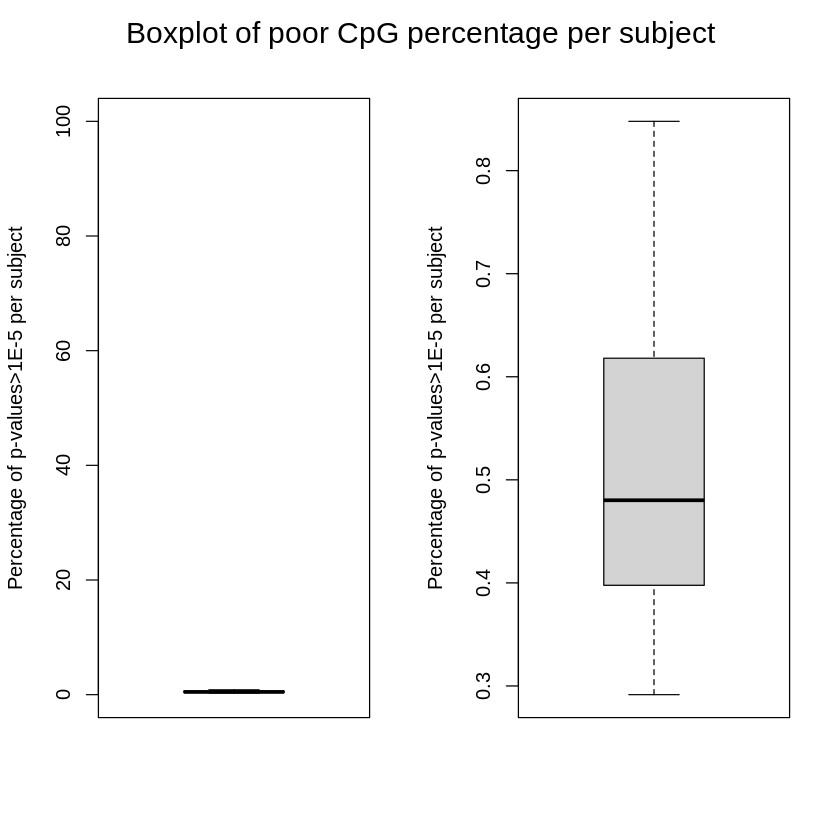

In [11]:
par(mfrow = c(1,2))
boxplot(subjectPoorCpgPercentage*100, ylab = "Percentage of p-values>1E-5 per subject", ylim = c(0,100))
boxplot(subjectPoorCpgPercentage*100, ylab = "Percentage of p-values>1E-5 per subject")
mtext("Boxplot of poor CpG percentage per subject", side = 3, line = -2, outer = TRUE, cex = 1.5)
par(mfrow = c(1,1))

In [12]:
medianCpgDetPval = apply(detect.p, 1, median)
poorCpgIndex = medianCpgDetPval>0.05

In [ ]:
jpeg("boxplot_medianCpgDetPval2.jpeg") # pdf("boxplot_medianCpgDetPval.pdf")
boxplot(medianCpgDetPval, ylab = "Median CpG detection p-value across subjects", 
        main = "Boxplot of median CpG detection p-value across subjects")
abline(h=0.05, col = "red")
text(1.2, 0.5, paste("n=",sum(poorCpgIndex),sep = ""))
dev.off()

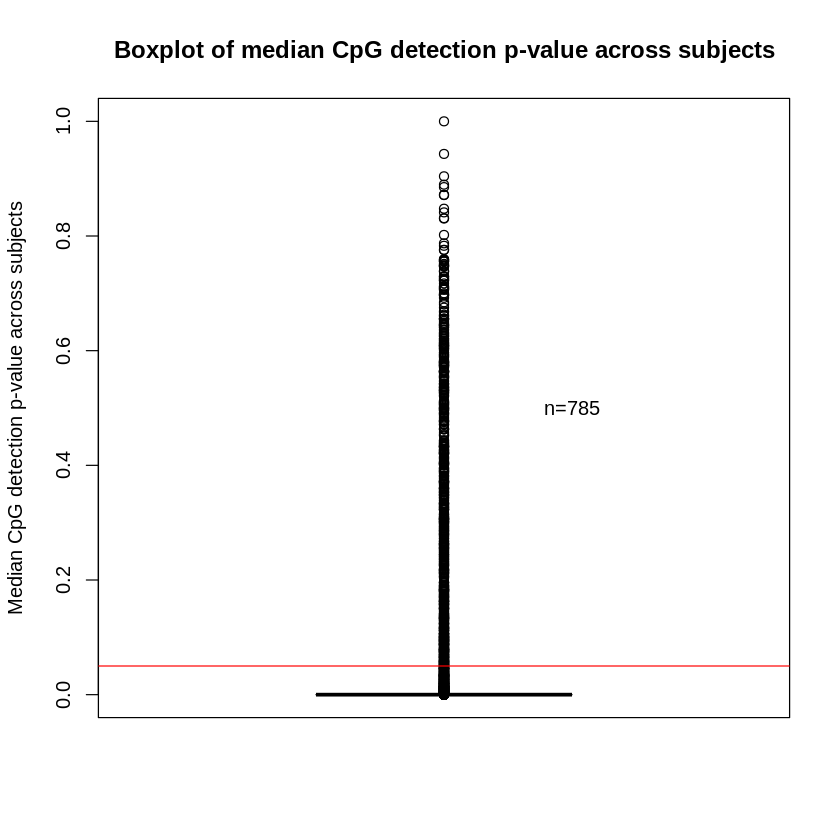

In [13]:

boxplot(medianCpgDetPval, ylab = "Median CpG detection p-value across subjects", 
        main = "Boxplot of median CpG detection p-value across subjects")
abline(h=0.05, col = "red")
text(1.2, 0.5, paste("n=",sum(poorCpgIndex),sep = ""))

In [14]:
# Beta matrix
if(!(identical(rownames(betas), names(poorCpgIndex)))) stop("betas dont match p-values")
betas_filtered = betas[!poorCpgIndex,] # 866091 -> 865306


In [15]:
# missing anno CpGs
cpgsWithoutAnno = rownames(betas_filtered)[!(rownames(betas_filtered) %in% anno$Name)]
betas_filtered = betas_filtered[!(rownames(betas_filtered) %in% cpgsWithoutAnno),]


In [16]:
# Probe design matrix
if(!(identical(anno$Name[anno$Name %in% rownames(betas_filtered)], rownames(betas_filtered)))) stop("annotation dont match p-values")
infTypes = ifelse(anno$Type[anno$Name %in% rownames(betas_filtered)] == "I", 1, 2)


<b>Reduction of probe type bias:</b> <p>An important objective of normalizing the Illumina 450K data is to reduce the bias caused by the use of the 2 types of probes. Therefore, we drew density plots of methylation b-values for each sample using raw and normalized 450K data(Fig.5),where the red line represents the densities of Type I probes for a sample and a blue line represents the densities of Type II probes for a sample. It is shown that QN, ASMN, Dasen,and SWAN do not fully remove probe type bias; in contrast QN.BMIQ, BMIQ, PBC, and SQN eliminate the bias between the 2 probe types. These results are similar to those reported by other researchers. However, for SQN, although the bias is reduced, the correlation/difference between the WGBS and its normalized 450K data, and that between technical replicates, is severely compromised, which was already shown in the above analyses. Hence, PBC and QN. BMIQ could be the most efficient normalization methods.</p> <p> https://doi.org/10.1080/15592294.2015.1057384 </p>
<img src="https://www.tandfonline.com/na101/home/literatum/publisher/tandf/journals/content/kepi20/2015/kepi20.v010.i07/15592294.2015.1057384/20151020/images/medium/kepi_a_1057384_f0005_oc.gif" alt="BMIQ" width="700" height="700">

<p> <b>BMIQ</b> is an intra-sample normalisation procedure, correcting the bias of type-2 probe values. BMIQ uses a 3-step procedure: (i) fitting of a 3-state beta mixture model, (ii) transformation of statemembership probabilities of type2 probes into quantiles of the type1 distribution, and (iii) a conformal transformation for the hemi-methylated probes.</p>

In [18]:
# WateRmelon
# BMIQ: Beta-Mixture Quantile Normalisation (probe 2 adjustment)
bmiqSet = NULL
for(i in 1:dim(betas_filtered)[2]){
  print(i)
  tmpBmiqSet = BMIQ(beta.v = betas_filtered[,i], design.v = infTypes, plots = FALSE) # requires RPMM; package install.packages("RPMM")
  bmiqSet = cbind(bmiqSet, tmpBmiqSet$nbeta)
}
rm(tmpBmiqSet)
colnames(bmiqSet) = colnames(betas_filtered)

[1] 1
[1] "Fitting EM beta mixture to type1 probes"
[1] Inf
[1] 0.008433371
[1] 0.009559778
[1] 0.008837421
[1] 0.007471865
[1] "Done"
[1] "Fitting EM beta mixture to type2 probes"
[1] Inf
[1] 0.01343335
[1] 0.01052123
[1] 0.008791144
[1] 0.007458284
[1] "Done"
[1] "Start normalising type 2 probes"
[1] "Finished for sample 1"
[1] 2
[1] "Fitting EM beta mixture to type1 probes"
[1] Inf
[1] 0.007867568
[1] 0.009206508
[1] 0.008590948
[1] 0.007482568
[1] "Done"
[1] "Fitting EM beta mixture to type2 probes"
[1] Inf
[1] 0.01216453
[1] 0.009403163
[1] 0.007851337
[1] 0.006701551
[1] "Done"
[1] "Start normalising type 2 probes"
[1] "Finished for sample 1"
[1] 3
[1] "Fitting EM beta mixture to type1 probes"
[1] Inf
[1] 0.007544886
[1] 0.009065703
[1] 0.008499536
[1] 0.007280046
[1] "Done"
[1] "Fitting EM beta mixture to type2 probes"
[1] Inf
[1] 0.01295612
[1] 0.01013687
[1] 0.008512386
[1] 0.007274502
[1] "Done"
[1] "Start normalising type 2 probes"
[1] "Finished for sample 1"
[1] 4
[1] "Fitt

In [ ]:
jpeg("BMIQ_density2.jpeg") # pdf("BMIQ_density.pdf")
plot(density(betas_filtered[ infTypes==1,]), col = "red", main = "Density plot of probe 1/2 before/after BMIQ", lwd = 2)
lines(density(betas_filtered[ infTypes==2,]), col = "green", lwd = 2)
lines(density(bmiqSet[ infTypes==1,]), col = "blue", lty = 2, lwd = 2)
lines(density(bmiqSet[ infTypes==2,]), col = "yellow", lwd = 2)
legend("topright", legend = c("Probe1 before BMIQ", "Probe2 before BMIQ", "Probe1 after BMIQ", "Probe2 after BMIQ"), col = c("red", "green", "blue", "yellow"), lty = c(1,1,2,1), lwd = 2)
dev.off()

colnames(bmiqSet) = targets$Sample_Name

In [ ]:
# BMIQ Density plot
plot(density(betas_filtered[ infTypes==1,]), col = "red", main = "Density plot of probe 1/2 before/after BMIQ", lwd = 2)
lines(density(betas_filtered[ infTypes==2,]), col = "green", lwd = 2)
lines(density(bmiqSet[ infTypes==1,]), col = "blue", lty = 2, lwd = 2)
lines(density(bmiqSet[ infTypes==2,]), col = "yellow", lwd = 2)
legend("topright", legend = c("Probe1 before BMIQ", "Probe2 before BMIQ", "Probe1 after BMIQ", "Probe2 after BMIQ"), col = c("red", "green", "blue", "yellow"), lty = c(1,1,2,1), lwd = 2)


colnames(bmiqSet) = targets$Sample_Name

In [ ]:
save(bmiqSet, targets, anno, file = "bmiqSet.Rdata") # 

In [ ]:
# Save an object to a file
saveRDS(bmiqSet, file = "bmiqset1.rds")

In [ ]:
load("bmiqSet.Rdata")

# Restore the object
#bmiqSet <- readRDS(file = "bmiqset1.rds")

In [ ]:
library("GGally") 
library(ggfortify) 
#library(ggplot2)


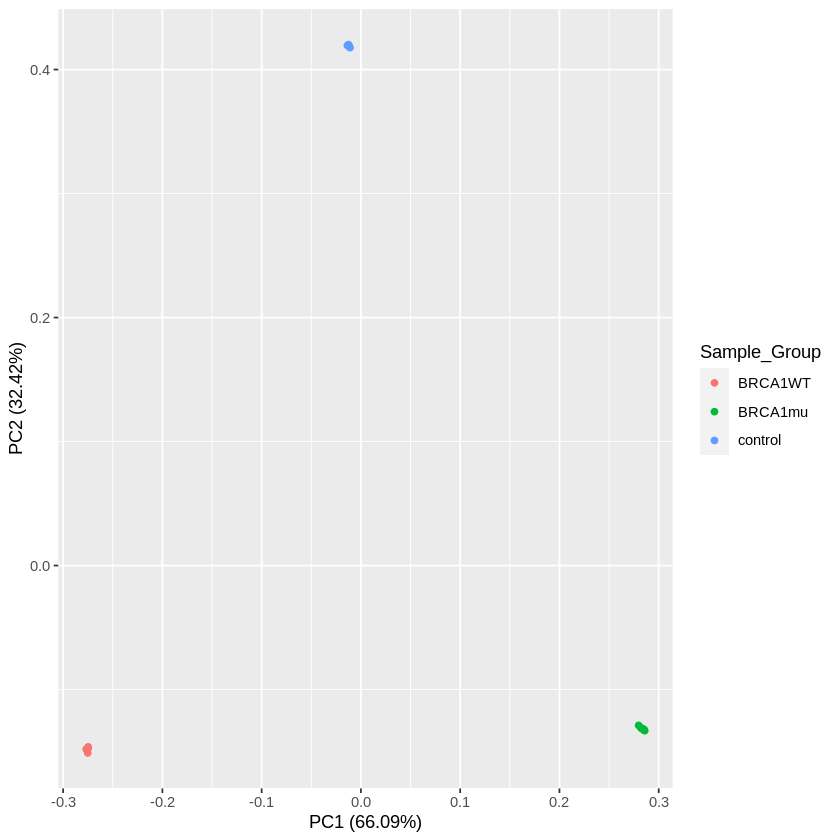

In [19]:

pca = stats::prcomp(t(bmiqSet))
rownames(targets) = targets$Sample_Name
#pdf("PCA2.pdf")
#ggplot2::autoplot(pca, data = targets, colour = "Sample_Group", x = 1, y = 2, label  = TRUE)
ggplot2::autoplot(pca, data = targets, colour = "Sample_Group", x = 1, y = 2)
#dev.off()

In [ ]:
head(bmiqSet)

In [ ]:
############################ DMA limm: Control - WT ##########################

idx = targets$Sample_Group %in% c("control", "BRCA1WT")

mvals = log2(bmiqSet[,idx] / (1-bmiqSet[,idx]))
groups = factor(targets$Sample_Group[idx], levels = c("control", "BRCA1WT"))
design = model.matrix(~ groups)
design

In [ ]:
limmaFit = lmFit(mvals, design)
pval = eBayes(limmaFit)$p.value[,2]
fdr = p.adjust(pval, method = "fdr"); min(fdr)

In [ ]:
# summarize results in table
results = data.frame(names = names(pval), pvalue = pval, FDR = fdr, genes = anno[names(pval), "UCSC_RefGene_Name"], bmiqSet[,idx])
results = results[order(results$pvalue),]
#write.csv(results, file = "results_cnt-wt_test.csv", quote = F, row.names = F)
# results[results$FDR<0.05,] 
head(results)


In [ ]:
# significant cpgs and genes
signCpg = results[results$FDR<0.05,]$names # signCpg = rownames(results)[1:10]
length(signCpg)
signGenes = anno[rownames(anno)%in% signCpg,]$UCSC_RefGene_Name
signGenes = unique(unlist(strsplit(signGenes, ";")))
length(signGenes)
head(signGenes)


In [20]:
## boxplot of significant CpG 
boxplot(bmiqSet[signCpg[1],idx] ~ groups, main = signCpg[1], ylab = "Beta-Value", xlab = "Groups")

ERROR: Error in eval(predvars, data, env): object 'signCpg' not found


In [ ]:
## save genes
write.table(signGenes, file = "signGenes_cnt-wt.txt", row.names = F, sep = "\n", col.names = F, quote = F)

In [ ]:
getwd()
sessionInfo()